In [ ]:
# import

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001

In [ ]:
# Load CIFAR-100 dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 93916380.89it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class GaussianNoiseLayer(nn.Module):
    def __init__(self, std_dev):
        super(GaussianNoiseLayer, self).__init__()
        self.std_dev = std_dev
    def forward(self, x):
        noise = torch.randn_like(x) * self.std_dev
        return x + noise

In [ ]:
class LatentSpaceClassfier(nn.Module):
    def __init__(self):
        super(LatentSpaceClassfier, self).__init__()
        self.gaussian_noise = GaussianNoiseLayer(std_dev=0.1)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        self.batch2 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(32 * 8 * 8, 10)
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = (8*8*16)*x/torch.norm(x)
        x = self.gaussian_noise(x)
        return x


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU for training.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU for training.")


# Set the number of classes in CIFAR-10
num_classes = 10

# Create an instance of the CNN model
model = LatentSpaceClassfier().to(device)

CUDA is not available. Using CPU for training.


In [ ]:
# define transforms for images
transform = transforms.Compose(
              [transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=32, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Set the model to evaluation mode
model.train()

# Print the modified model architecture
print(model)

LatentSpaceClassfier(
  (gaussian_noise): GaussianNoiseLayer()
  (relu): ReLU()
  (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
)


In [ ]:

from torchsummary import summary

summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3              [-1, 8, 8, 8]           1,160
              ReLU-4              [-1, 8, 8, 8]               0
GaussianNoiseLayer-5              [-1, 8, 8, 8]               0
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [ ]:
import numpy as np
labels_train = []  # Store the labels
features_train = []
for images, labels in train_loader:
    images = images.to(device)
    outputs = model(images)
    features_train.append(outputs.detach())
    labels_train.extend(labels)  # Save the labels



encoder_features_train = torch.cat(features_train, dim=0)
labels_train = np.array(labels_train)
# Reshape encoder features
encoder_features_train = encoder_features_train.view(encoder_features_train.size(0), -1)
encoder_features_train = encoder_features_train.to('cpu').numpy()
print(encoder_features_train.shape)

(50000, 512)


In [ ]:
import numpy as np
labels_test = []  # Store the labels
features_test = []
for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)
    features_test.append(outputs.detach())
    labels_test.extend(labels)  # Save the labels



encoder_features_test = torch.cat(features_test, dim=0)
labels_test = np.array(labels_test)
# Reshape encoder features
encoder_features_test = encoder_features_test.view(encoder_features_test.size(0), -1)
encoder_features_test = encoder_features_test.to('cpu').numpy()
print(encoder_features_test.shape)

(10000, 512)


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
# Move the encoder features and labels to CPU and convert to NumPy arrays
# encoder_features_train_np = np.concatenate([tensor.cpu().numpy() for tensor in encoder_features_train], axis=0)


# Create the decision tree classifier
classifier = DecisionTreeClassifier(max_depth = 9)

predicted_labels = []
# Train the classifier
classifier.fit(encoder_features_train, labels_train)


DecisionTreeClassifier(max_depth=9)

In [ ]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
y_pred_train = classifier.predict(encoder_features_train)
accuracy_train = accuracy_score(y_pred_train, labels_train)

print("Accuracy:", accuracy_train)

Accuracy: 0.34594


In [ ]:
predicted_labels = classifier.predict(encoder_features_test)
accuracy_test = accuracy_score(predicted_labels, labels_test)

print("Accuracy:", accuracy_test)

Accuracy: 0.2878


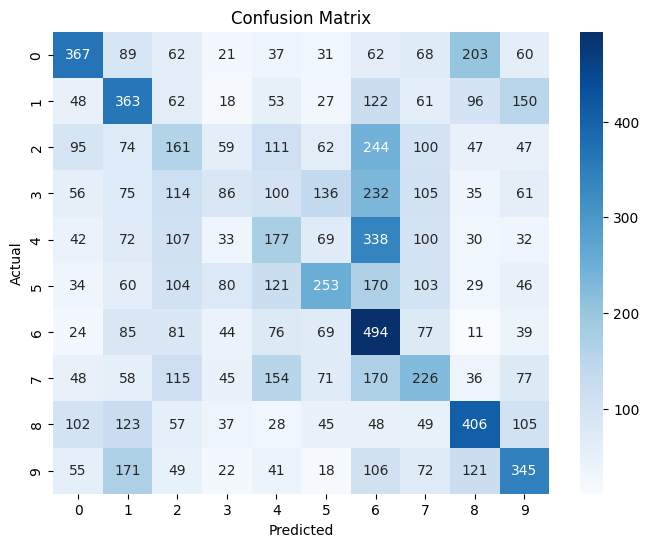

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(labels_test, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
# Calculate F1 score
f1 = f1_score(predicted_labels, labels_test, average='weighted')

print("F1 Score:", f1)

F1 Score: 0.2954839068300919


In [ ]:
tree = classifier.tree_
# Count the nodes and branches
num_internal_nodes = tree.node_count - classifier.tree_.n_leaves
num_leaf_nodes = classifier.tree_.n_leaves
num_branches = 2 * num_internal_nodes  # Assuming binary splits

# Print the counts
print("Number of internal nodes:", num_internal_nodes)
print("Number of leaf nodes:", num_leaf_nodes)
print("Number of branches:", num_branches)

# Access the root node
root_node = 0  # The root node index is always 0

# Print the root node
print("Root node:", root_node)

Number of internal nodes: 490
Number of leaf nodes: 491
Number of branches: 980
Root node: 0
